Medway - Local Election Results - 2023
======================================

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
from glob import glob
import re

from matplotlib import pyplot as plt

import seaborn as sns

from IPython.display import display, HTML

### TODO

[ ] Rejection reasons - add to df_ward  
[ ] Determine number of candidates for each ward (ward_seats)

### 1. Config

In [2]:
# Paths
path_data = 'data'

# Medway Council - Local Election Results 2023 website
url_results = "https://www.medway.gov.uk/results2023"

In [3]:
# Ward seats
ward_seats = {
    "All Saints": 1,
    "Chatham Central and Brompton": 3,
    "Cuxton, Halling and Riverside": 2,
    "Fort Horsted": 1,
    "Fort Pitt": 3,
    "Gillingham North": 3,
    "Gillingham South": 3,
    "Hempstead and Wigmore": 2,
    "Hoo St Werburgh and High Halstow": 3,
    "Lordswood and Walderslade": 3,
    "Luton": 2,
    "Princes Park": 2,
    "Rainham North": 3,
    "Rainham South East": 3,
    "Rainham South West": 2,
    "Rochester East and Warren Wood": 3,
    "Rochester West and Borstal": 3,
    "St Mary's Island": 1,
    "Strood North and Frindsbury": 3,
    "Strood Rural": 3,
    "Strood West": 3,
    "Twydall": 2,
    "Watling": 3,
    "Wayfield and Weeds Wood": 2
 }
assert sum([x for x in ward_seats.values()]) == 59

In [4]:
# Party map
map_party = {
       "Conservative Party candidate": "Conservative",
       "Labour and Co-operative Party": "Labour",
       "Labour Party": "Labour",
       "Local Conservatives": "Conservative",
}

In [5]:
# Colours map
x = sns.color_palette("Paired")
print(x.as_hex())
display(x)

map_colors = {
       "Christian Peoples Alliance": "#ffff99",
       "Conservative Party candidate": "#1f78b4",
       "Conservative": "#1f78b4",
       "Green Party": "#33a021",
       "Heritage Party": "#fdbf6f",
       "Independent": "#ff7f00",
       "Labour and Co-operative Party": "#fb9a99",
       "Labour Party": "#e31a1c",
        "Labour": "#e31a1c",
       "Liberal Democrats": "#cab2d6",
       "Local Conservatives": "#a6cee3",
       "Reform UK": "#b15928",
       "Social Democratic Party": "#6a3d9a"
}



['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

### 1. Get results data from website or cache

In [6]:
path_results = f'{path_data}/results.html'



if os.path.exists(path_results):
    print('Results cache exists - loading from disk')
    with open(path_results) as fh:
        html_results = fh.read()

else:
    print('No results cache found - requesting from url and caching')
    html_results = requests.get(url=url_results).content
    with open(path_results, "wb") as fh:
        fh.write(html_results)

print(len(html_results))


Results cache exists - loading from disk
38439


### 2. Get Ward data from website or cache

In [7]:
# Get ward data

soup = BeautifulSoup(html_results)

ward_as = soup.find("h2", string="Ward election results").find_next('p').find_all('a')
for ward_a in ward_as:
    ward = ward_a.text
    ward_url = ward_a.get('href')
    
    print(f'{ward}: ', end='')
    save_path = f'{path_data}/wards/{ward}.html'

    if os.path.exists(save_path):
        print('Cache found')
    else:
        print('Cache not found - requesting from url and caching')
        html = requests.get(ward_url).text
        with open(save_path, 'w') as fh_out:
            fh_out.write(html)

All Saints: Cache found
Chatham Central and Brompton: Cache found
Cuxton, Halling and Riverside: Cache found
Fort Horsted: Cache found
Fort Pitt: Cache found
Gillingham North: Cache found
Gillingham South: Cache found
Hempstead and Wigmore: Cache found
Hoo St Werburgh and High Halstow: Cache found
Lordswood and Walderslade: Cache found
Luton: Cache found
Princes Park: Cache found
Rainham North: Cache found
Rainham South East: Cache found
Rainham South West: Cache found
Rochester East and Warren Wood: Cache found
Rochester West and Borstal: Cache found
St Mary's Island: Cache found
Strood North and Frindsbury: Cache found
Strood Rural: Cache found
Strood West: Cache found
Twydall: Cache found
Watling: Cache found
Wayfield and Weeds Wood: Cache found


In [8]:
# Load ward property data 
# Ward property data is stuff like the number of electors etc.
ward_objs = []

for ward_a in ward_as:

    ward = ward_a.text
    ward_url = ward_a.get('href')
    print(f'{ward}: Processing')
    
    ward_obj = {
        'ward': ward,
        'url': ward_url
    }
    path_html_ward = f'{path_data}/wards/{ward}.html'
    with open(path_html_ward) as fh:
        soup = BeautifulSoup(fh.read())
        lis = soup.find("h2", string="Verification statement").find_next('ul').find_all('li')
        
        if len(lis) > 0:
            for li in lis:
                item, val = li.text.split(':')
                item = (
                    item
                    .replace('The total number of', '')
                    .replace('from the polling stations', '')
                    .replace('The', '')
                    .replace('as of today', '')
                    .strip()
                    .lower()
                    .replace(' ', '_')
                )
                ward_obj[item] = val.strip().replace(',','')
        
        # Ward seats
        ward_obj['ward_seats'] = ward_seats.get(ward)

        ward_objs.append(ward_obj)
        
        # raise KeyboardInterrupt

df_wards = (
    pd.DataFrame(ward_objs)
    .astype({
        'verified_ballot_papers': 'int',
        'verified_postal_ballot_papers': 'int',
        'ballot_papers_verified': 'int',
        'electorate':'int'
    })
    .assign(**{'turnout': lambda _df:_df['ballot_papers_verified'] / _df['electorate']})
)

display(df_wards.head())
display(df_wards.dtypes)


All Saints: Processing
Chatham Central and Brompton: Processing
Cuxton, Halling and Riverside: Processing
Fort Horsted: Processing
Fort Pitt: Processing
Gillingham North: Processing
Gillingham South: Processing
Hempstead and Wigmore: Processing
Hoo St Werburgh and High Halstow: Processing
Lordswood and Walderslade: Processing
Luton: Processing
Princes Park: Processing
Rainham North: Processing
Rainham South East: Processing
Rainham South West: Processing
Rochester East and Warren Wood: Processing
Rochester West and Borstal: Processing
St Mary's Island: Processing
Strood North and Frindsbury: Processing
Strood Rural: Processing
Strood West: Processing
Twydall: Processing
Watling: Processing
Wayfield and Weeds Wood: Processing


,ward,url,verified_ballot_papers,verified_postal_ballot_papers,ballot_papers_verified,electorate,turnout,ward_seats
0,All Saints,https://www.medway.gov.uk/info/200670/local_an...,634,331,965,3495,0.276109,1
1,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,1194,1007,2201,10525,0.209121,3
2,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,1368,527,1895,6129,0.309186,2
3,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,717,373,1090,3530,0.308782,1
4,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,1904,1190,3094,9170,0.337405,3


ward                              object
url                               object
verified_ballot_papers             int64
verified_postal_ballot_papers      int64
ballot_papers_verified             int64
electorate                         int64
turnout                          float64
ward_seats                         int64
dtype: object

In [9]:
# Load ward result data into DataFrame
dfs = []

for ward_a in ward_as:
    ward = ward_a.text
    ward_url = ward_a.get('href')
    print(f'{ward}: Processing')
    path_html_ward = f'{path_data}/wards/{ward}.html'
    with open(path_html_ward) as fh:
        soup = BeautifulSoup(fh.read())
        page_tables = soup.find_all('table')
        
        df = (
            pd.read_html(str(page_tables[0]), header=0)[0]
            .rename(columns={'Descriptions': 'Description'})
            .assign(**{
                'ward': ward,
                'ward_result_url': ward_url,
                'Description': lambda _df: _df['Description'].str.replace('party', 'Party'),
                'common_name': lambda _df: _df['Other names'].str.extract(r'(?:also|commonly) known as ([^)]+)\)?',flags=re.IGNORECASE),
                'surname': lambda x: x['Surname'].str.extract(r'(.+?)(?=\s\()'),
                'party': lambda x: x['Description'].map(map_party)
            })
            # Fillnas
            .assign(**{
                'common_name': lambda _df: _df['common_name'].fillna(_df['Other names']),
                'surname': lambda _df: _df['surname'].fillna(_df['Surname']),
                'party': lambda _df: _df['party'].fillna(_df['Description'])
              })
        )
        
        dfs.append(df)

        # display(df.head())
        
df_results = pd.concat(dfs)

df_results.sample(10)
        

All Saints: Processing
Chatham Central and Brompton: Processing
Cuxton, Halling and Riverside: Processing
Fort Horsted: Processing
Fort Pitt: Processing
Gillingham North: Processing
Gillingham South: Processing
Hempstead and Wigmore: Processing
Hoo St Werburgh and High Halstow: Processing
Lordswood and Walderslade: Processing
Luton: Processing
Princes Park: Processing
Rainham North: Processing
Rainham South East: Processing
Rainham South West: Processing
Rochester East and Warren Wood: Processing
Rochester West and Borstal: Processing
St Mary's Island: Processing
Strood North and Frindsbury: Processing
Strood Rural: Processing
Strood West: Processing
Twydall: Processing
Watling: Processing
Wayfield and Weeds Wood: Processing


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
8,Wild,Michael Dennis,Liberal Democrats,159,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Michael Dennis,Wild,Liberal Democrats
3,Gibson,John Wesley,Christian Peoples Alliance,50,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,John Wesley,Gibson,Christian Peoples Alliance
7,Shokar,Satinder Singh,Labour and Co-operative Party,1236,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Satinder Singh,Shokar,Labour
0,Atkinson,Neil James,Green Party,379,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Neil James,Atkinson,Green Party
7,Shah,Alpa Arya,Labour Party,498,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Alpa Arya,Shah,Labour
6,Marchant,Patricia Anne (commonly known as Trish Marchant),Green Party,442,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Trish Marchant,Marchant,Green Party
5,Spalding,Christopher Stuart (commonly known as Chris Sp...,Independent,295,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Chris Spalding,Spalding,Independent
4,Munton,Derek,Labour Party,742,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Derek,Munton,Labour
6,Vincent,Matthew William,Liberal Democrats,272,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Matthew William,Vincent,Liberal Democrats
7,Tejan,Habib Odunlamin,Local Conservatives,467,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Habib Odunlamin,Tejan,Conservative


### 3. Analysis

Seats: 1


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,Spalding,Christopher Stuart (commonly known as Chris Sp...,Independent,295,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Chris Spalding,Spalding,Independent
6,Wallace,Julie,Independent,252,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Julie,Wallace,Independent
3,Ogunfemi,Habeeb Adeyemi (commonly known as Harold Ogunf...,Local Conservatives,190,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Harold Ogunfemi,Ogunfemi,Conservative
1,Kemp,Kier Dorran,Labour Party,118,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Kier Dorran,Kemp,Labour
2,Khatkar,Harjinder Singh (commonly known as Bill Khatkar),Reform UK,49,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Bill Khatkar,Khatkar,Reform UK
0,Hyde,Bernard Edward,Green Party,34,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Bernard Edward,Hyde,Green Party
4,Simpson,Elizabeth Ann,Liberal Democrats,22,All Saints,https://www.medway.gov.uk/info/200670/local_an...,Elizabeth Ann,Simpson,Liberal Democrats


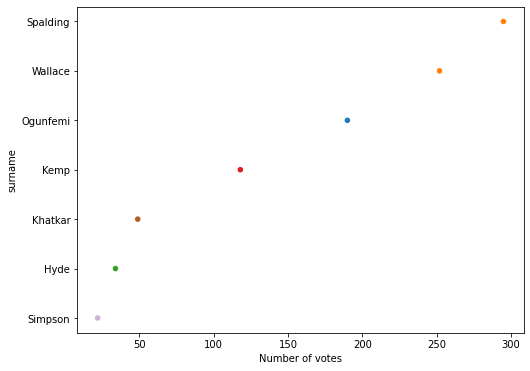

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,Maple,Vincent Stewart (commonly known as Vince Maple),Labour and Co-operative Party,1394,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Vince Maple,Maple,Labour
1,Gurung,Nina,Labour and Co-operative Party,1211,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Nina,Gurung,Labour
0,Animashaun,Shakirat Oyindamola (Commonly known as Damola ...,Labour and Co-operative Party,1136,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Damola Animashaun,Animashaun,Labour
3,Khera,Vrinderpal Singh (commonly known as Paul Khera),Local Conservatives,552,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Paul Khera,Khera,Conservative
4,King,Claude Jenner Granville,Local Conservatives,517,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Claude Jenner Granville,King,Conservative
7,Tejan,Habib Odunlamin,Local Conservatives,467,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Habib Odunlamin,Tejan,Conservative
6,O'Hanlon,Robert Gerald Edward (commonly known as Rob O'...,Green Party,336,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Rob O'Hanlon,O'Hanlon,Green Party
2,Juby,Geoffrey William (commonly known as Geoff Juby),Liberal Democrats,295,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,Geoff Juby,Juby,Liberal Democrats


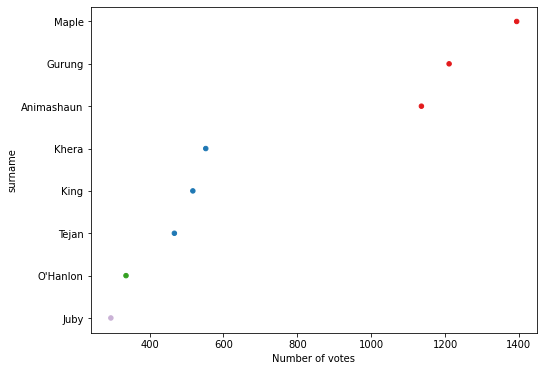

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
0,Fearn,Matthew James (commonly known as Matt Fearn),Local Conservatives,880,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Matt Fearn,Fearn,Conservative
1,Filmer,Phillip (commonly known as Phil Filmer),Local Conservatives,685,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Phil Filmer,Filmer,Conservative
6,Nightingale,Matthew Richard (commonly known as Matt Nighti...,Green Party,641,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Matt Nightingale,Nightingale,Green Party
3,Jamieson,Catriona Margaret (commonly known as Cat Jamie...,Green Party,502,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Cat Jamieson,Jamieson,Green Party
4,McCormack,Stephen Joseph Donald,Labour Party,414,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Stephen Joseph Donald,McCormack,Labour
5,Morris,Victoria Valerie,Labour Party,408,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Victoria Valerie,Morris,Labour
2,Gillett,Ronald Arcon (commonly known as Ron Gillett),Liberal Democrats,76,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,Ron Gillett,Gillett,Liberal Democrats


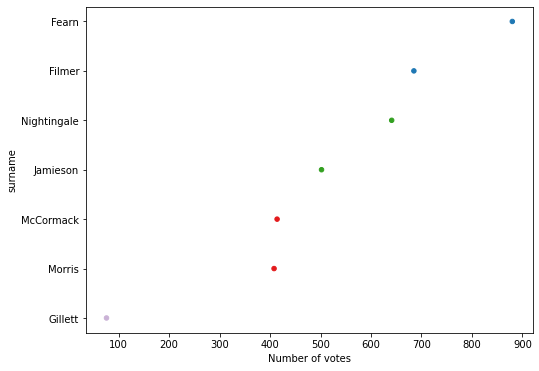

Seats: 1


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
0,Clarke,Trevor Anthony,Local Conservatives,489,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Trevor Anthony,Clarke,Conservative
3,Parker,Vivienne (commonly known as Viv Parker),Liberal Democrats,344,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Viv Parker,Parker,Liberal Democrats
2,Murray,Joseph Simon,Labour Party,212,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Joseph Simon,Murray,Labour
1,Knott,Matthews John,Green Party,37,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,Matthews John,Knott,Green Party


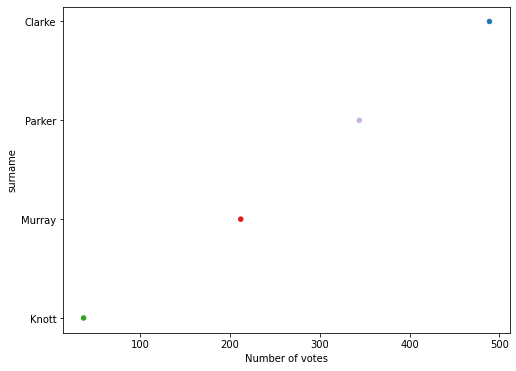

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
0,Campbell,Smitha,Labour and Co-operative Party,1726,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Smitha,Campbell,Labour
1,Mahil,Harinder Singh,Labour and Co-operative Party,1634,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Harinder Singh,Mahil,Labour
2,Myton,Richard Gareth,Labour and Co-operative Party,1577,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Richard Gareth,Myton,Labour
7,Turpin,Rupert David Fearon,Local Conservatives,1028,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Rupert David Fearon,Turpin,Conservative
6,Thorne,Richard Niall,Local Conservatives,951,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Richard Niall,Thorne,Conservative
3,Opara,Gloria Blessing Chukwuka,Local Conservatives,901,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Gloria Blessing Chukwuka,Opara,Conservative
5,Scott,Karen,Green Party,527,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Karen,Scott,Green Party
4,Sandhu,Nirmal,Liberal Democrats,249,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,Nirmal,Sandhu,Liberal Democrats


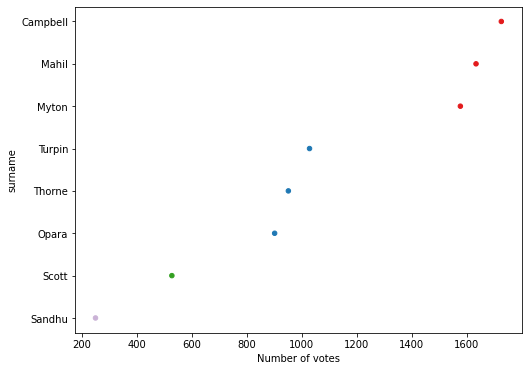

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
4,Price,Adam Robert William,Labour and Co-operative Party,1419,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Adam Robert William,Price,Labour
2,Hamandishe,Douglas Kudakwashe,Labour and Co-operative Party,1355,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Douglas Kudakwashe,Hamandishe,Labour
3,Mandaracas,Lia Helen,Labour and Co-operative Party,1339,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Lia Helen,Mandaracas,Labour
0,Barrett,Clayton,Conservative Party candidate,530,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Clayton,Barrett,Conservative
1,Chishti,Zarina Bibi,Conservative Party candidate,439,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Zarina Bibi,Chishti,Conservative
6,Sidhu,Harbans Singh,Conservative Party candidate,410,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Harbans Singh,Sidhu,Conservative
7,Spyby-Steanson,Jeremy,Green Party,340,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Jeremy,Spyby-Steanson,Green Party
5,Rist,Ben Darryl,Liberal Democrats,254,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,Ben Darryl,Rist,Liberal Democrats


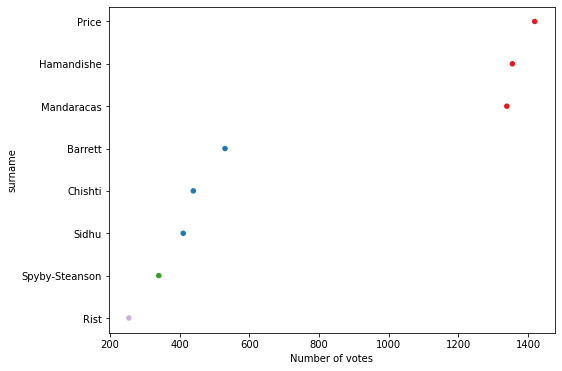

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
4,McDonald,Rory Craig (commonly known as Dan McDonald),Labour and Co-operative Party,1617,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Dan McDonald,McDonald,Labour
3,Khan,Naushabah Parveen,Labour and Co-operative Party,1531,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Naushabah Parveen,Khan,Labour
5,Prenter,Louwella Margaret,Labour and Co-operative Party,1491,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Louwella Margaret,Prenter,Labour
7,Smith,Amy,Conservative Party candidate,509,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Amy,Smith,Conservative
0,Adeoye,Sijuwade Adenike (commonly known as Siju Adeoye),Conservative Party candidate,471,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Siju Adeoye,Adeoye,Conservative
1,Belmonte,Daniel Luis,Green Party,373,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Daniel Luis,Belmonte,Green Party
2,Georghiou,George,Conservative Party candidate,373,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,George,Georghiou,Conservative
6,Sams,Christopher John,Liberal Democrats,322,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,Christopher John,Sams,Liberal Democrats


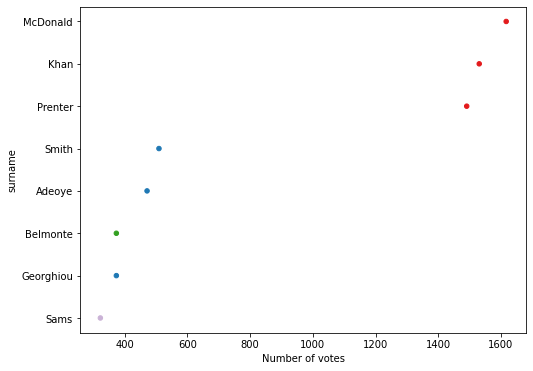

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
2,Gilbourne,James Adrian (commonly known as Jim Gilbourne),Conservative Party candidate,1709,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Jim Gilbourne,Gilbourne,Conservative
6,Lawrence,Andrew William John,Conservative Party candidate,1617,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Andrew William John,Lawrence,Conservative
0,Bailey,Lewis John William,Labour Party,603,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Lewis John William,Bailey,Labour
4,Kahn,Haroon Ali,Labour Party,450,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Haroon Ali,Kahn,Labour
5,Korff,Kathryn Amanda (commonly known as Kat Korff),Green Party,237,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Kat Korff,Korff,Green Party
1,Cavaliere,Daniele Erico Sergio (commonly known as Daniel...,Liberal Democrats,222,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Daniel Cavaliere,Cavaliere,Liberal Democrats
7,Wheeler,Peter Anthony,Social Democratic Party,58,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,Peter Anthony,Wheeler,Social Democratic Party
3,Gibson,John Wesley,Christian Peoples Alliance,50,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,John Wesley,Gibson,Christian Peoples Alliance


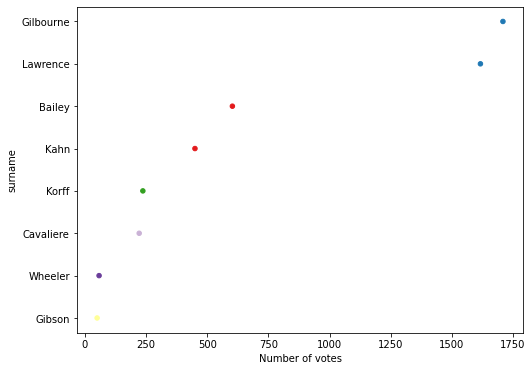

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
2,Crozer,George Josiah Thomas,Independent,2388,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,George Josiah Thomas,Crozer,Independent
6,Sands,Ronald Philip (commonly known as Ron Sands),Independent,2279,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Ron Sands,Sands,Independent
5,Pearce,Michael Ian,Independent,2230,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Michael Ian,Pearce,Independent
10,Tildesley,Robert John,Local Conservatives,465,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Robert John,Tildesley,Conservative
8,Sparks,Christopher John (commonly known as Chris Sparks),Local Conservatives,427,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Chris Sparks,Sparks,Conservative
4,Mitchell,Fatima,Local Conservatives,409,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Fatima,Mitchell,Conservative
0,Barwell,Gary,Labour Party,358,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Gary,Barwell,Labour
1,Christmas,Guiliana Paola,Labour Party,336,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Guiliana Paola,Christmas,Labour
11,Vickery,Stephen Allan,Labour Party,286,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Stephen Allan,Vickery,Labour
9,Sutton,Julian Charles,Green Party,140,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Julian Charles,Sutton,Green Party


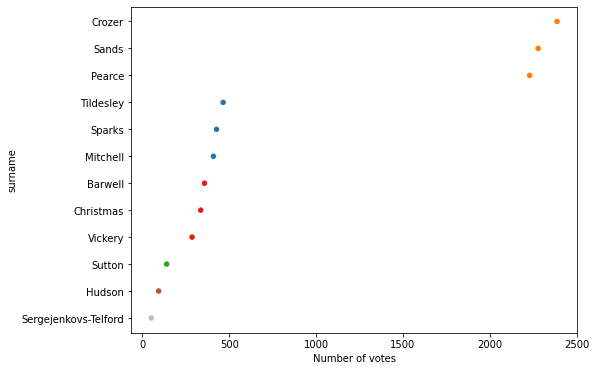

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
1,Brake,David Frederick,Local Conservatives,1752,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Frederick,Brake,Conservative
7,Wildey,David Robert,Local Conservatives,1728,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Robert,Wildey,Conservative
4,Gulvin,Adrian Victor Henry,Local Conservatives,1618,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Adrian Victor Henry,Gulvin,Conservative
3,Godwin,Christine Janice,Labour Party,917,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Christine Janice,Godwin,Labour
0,Bowen,David Alun,Labour Party,817,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Alun,Bowen,Labour
2,Cook,Bradley Charles George (commonly known as Brad...,Labour Party,777,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Brad Cook,Cook,Labour
5,Hyner,Sonia Lesley,Green Party,339,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Sonia Lesley,Hyner,Green Party
6,Vincent,Matthew William,Liberal Democrats,272,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,Matthew William,Vincent,Liberal Democrats


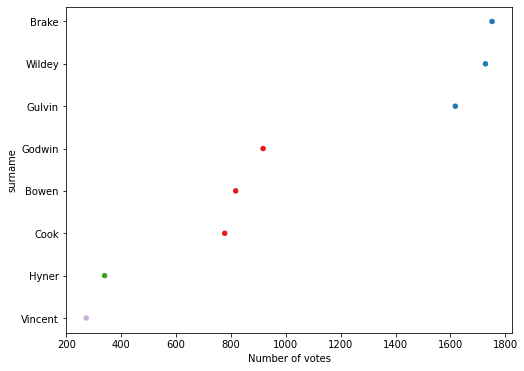

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
0,Curry,Simon Michael,Labour and Co-operative Party,796,Luton,https://www.medway.gov.uk/info/200670/local_an...,Simon Michael,Curry,Labour
1,Howcroft-Scott,Joanne Christine (commonly known as Jo Howcrof...,Labour and Co-operative Party,751,Luton,https://www.medway.gov.uk/info/200670/local_an...,Jo Howcroft-Scott,Howcroft-Scott,Labour
3,Lammas,Marianna Hendrika (commonly known as Lulu Lammas),Conservative Party candidate,541,Luton,https://www.medway.gov.uk/info/200670/local_an...,Lulu Lammas,Lammas,Conservative
2,Igani,Mosueneme (commonly known as Mos Igani),Conservative Party candidate,510,Luton,https://www.medway.gov.uk/info/200670/local_an...,Mos Igani,Igani,Conservative
5,Sutton,Deborah Susan (commonly known as Debbie Sutton),Green Party,174,Luton,https://www.medway.gov.uk/info/200670/local_an...,Debbie Sutton,Sutton,Green Party
4,O'Neill,Paul Anthony,Liberal Democrats,136,Luton,https://www.medway.gov.uk/info/200670/local_an...,Paul Anthony,O'Neill,Liberal Democrats


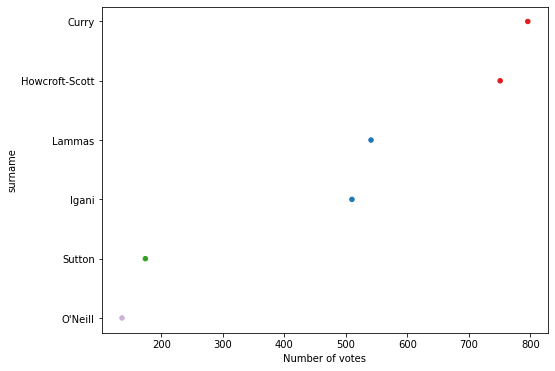

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
1,Lammas,Robert George Benedict (commonly known as Robb...,Conservative Party candidate,938,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Robbie Lammas,Lammas,Conservative
0,Hyne,Alexander Thomas (commonly known as Alex),Conservative Party candidate,933,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Alex,Hyne,Conservative
5,Strevens,John Gower,Labour Party,486,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,John Gower,Strevens,Labour
3,Olodo,Temitope Omontanwa (commonly known as Temi Olodo,Labour Party,425,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Temi Olodo,Olodo,Labour
2,Marchant,Simon Phillip,Green Party,156,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Simon Phillip,Marchant,Green Party
4,Sailes,Ian Christopher,Liberal Democrats,116,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,Ian Christopher,Sailes,Liberal Democrats


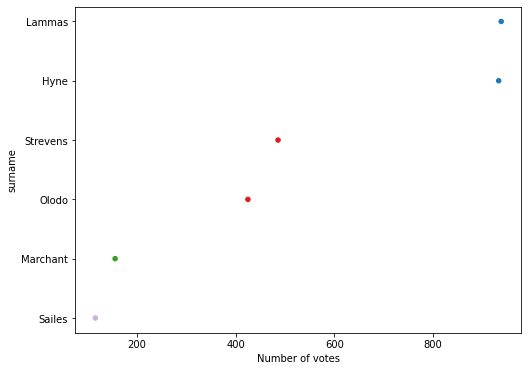

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
8,Perfect,George Harry,Conservative Party candidate,1210,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,George Harry,Perfect,Conservative
9,Spring,Wayne Ronald,Conservative Party candidate,1138,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Wayne Ronald,Spring,Conservative
0,Anang,Kwashie Amartei,Conservative Party candidate,1124,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Kwashie Amartei,Anang,Conservative
4,Harrison,Mark Richard,Labour Party,1025,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Mark Richard,Harrison,Labour
7,Morris,Nonchalonte Nikita (commonly known as Nikita M...,Labour Party,946,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Nikita Morris,Morris,Labour
5,Khan,Ahmed Mutahir (commonly known as Mutz Khan),Labour Party,907,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Mutz Khan,Khan,Labour
1,Bourne,Stuart James,Liberal Democrats,675,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Stuart James,Bourne,Liberal Democrats
6,Marchant,Patricia Anne (commonly known as Trish Marchant),Green Party,442,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Trish Marchant,Marchant,Green Party
3,Collins Rosell,Alan William,Liberal Democrats,402,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Alan William,Collins Rosell,Liberal Democrats
2,Chan,Yu Hin Nick (commonly known as Nicholas Chan),Liberal Democrats,323,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,Nicholas Chan,Chan,Liberal Democrats


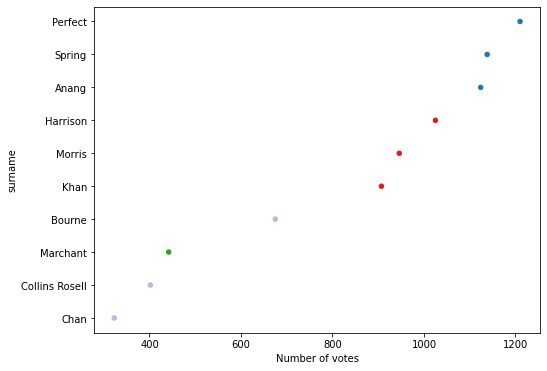

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
0,Barrett,Roger,Conservative Party candidate,1455,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Roger,Barrett,Conservative
3,Doe,Howard Francis,Conservative Party candidate,1448,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Howard Francis,Doe,Conservative
4,Hackwell,Gary John,Conservative Party candidate,1430,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Gary John,Hackwell,Conservative
1,Campbell,Katrina Karen,Labour Party,920,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Katrina Karen,Campbell,Labour
2,Childs,Iain Michael,Labour Party,835,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Iain Michael,Childs,Labour
6,Mottram,Chiron Peter,Labour Party,759,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Chiron Peter,Mottram,Labour
8,Smith,Mary Winifred,Green Party,431,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Mary Winifred,Smith,Green Party
5,Moore,Christopher Charles,Liberal Democrats,337,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Christopher Charles,Moore,Liberal Democrats
7,Peacock,Roger James,Christian Peoples Alliance,158,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,Roger James,Peacock,Christian Peoples Alliance


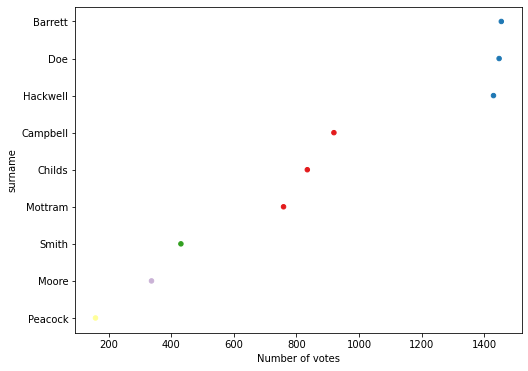

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,Kemp,Barry Joseph,Conservative Party candidate,1177,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Barry Joseph,Kemp,Conservative
4,Joy,Mark Paul,Conservative Party candidate,1027,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Mark Paul,Joy,Conservative
0,Brown,Christopher David,Labour Party,750,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Christopher David,Brown,Labour
7,Shah,Alpa Arya,Labour Party,498,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Alpa Arya,Shah,Labour
6,O'Hanlon,Elizabeth Lindsey (commonly known as Liz O'Han...,Green Party,341,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Liz O'Hanlon,O'Hanlon,Green Party
3,Jefferies,Alan John,Liberal Democrats,269,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Alan John,Jefferies,Liberal Democrats
1,Durcan,Matthew Bernard (commonly known as Matt Durcan),Independent,226,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Matt Durcan,Durcan,Independent
2,Evans,Callum John,Independent,96,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,Callum John,Evans,Independent


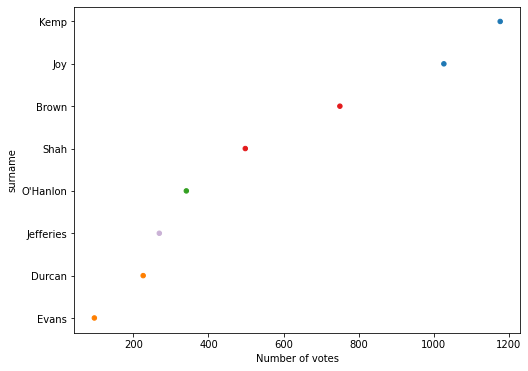

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
4,Murray,Teresa Margaret,Labour and Co-operative Party,1658,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Teresa Margaret,Murray,Labour
1,Edwards,Lauren Rae,Labour and Co-operative Party,1517,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Lauren Rae,Edwards,Labour
5,Osborne,Tristan John,Labour and Co-operative Party,1347,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Tristan John,Osborne,Labour
0,Clarke,George Harvey Samuel,Local Conservatives,784,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,George Harvey Samuel,Clarke,Conservative
2,Griffin,Sylvia Mary,Local Conservatives,755,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Sylvia Mary,Griffin,Conservative
6,Sirlan,Tolga,Local Conservatives,665,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Tolga,Sirlan,Conservative
7,Stone,Marilyn,Green Party,370,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Marilyn,Stone,Green Party
3,Manuel,Sarah Louise,Liberal Democrats,206,Rochester East and Warren Wood,https://www.medway.gov.uk/info/200670/local_an...,Sarah Louise,Manuel,Liberal Democrats


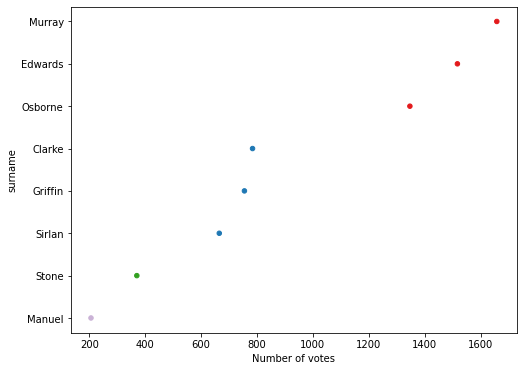

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,Paterson,Alexander John (commonly known as Alex Paterson),Labour and Co-operative Party,1807,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Alex Paterson,Paterson,Labour
0,Bowen,Linda Jill,Labour and Co-operative Party,1670,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Linda Jill,Bowen,Labour
1,Hamilton,Paula Wilhelmina,Labour and Co-operative Party,1624,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Paula Wilhelmina,Hamilton,Labour
6,Tranter,Stuart Albert,Local Conservatives,1336,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Stuart Albert,Tranter,Conservative
4,Ohaeri (also known as Rivers),Faith (commonly known as Faith Rivers),Local Conservatives,1080,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Faith Rivers,Ohaeri,Conservative
3,Joiner,Timothy Martin (commonly known as Tim Joiner),Local Conservatives,1010,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Tim Joiner,Joiner,Conservative
7,Worsley,Stuart Samuel,Green Party,536,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Stuart Samuel,Worsley,Green Party
2,Holloway,Anita Jane,Liberal Democrats,303,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Anita Jane,Holloway,Liberal Democrats


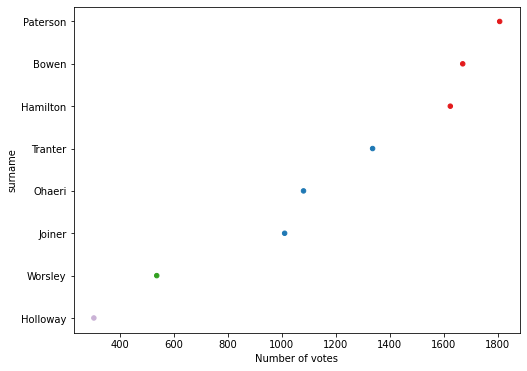

Seats: 1


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
3,Tejan,Habib Odunlamin Sulaiman,Local Conservatives,479,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,Habib Odunlamin Sulaiman,Tejan,Conservative
1,Castle,John Edward,Liberal Democrats,323,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,John Edward,Castle,Liberal Democrats
2,Hodges,David Christopher Graham,Labour Party,224,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,David Christopher Graham,Hodges,Labour
0,Bowes,Caroline Mary,Green Party,47,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,Caroline Mary,Bowes,Green Party


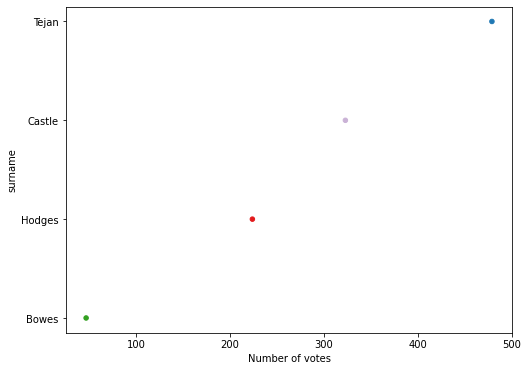

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
3,Dyke,Zoe Angela Van,Labour and Co-operative Party,1774,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Zoe Angela Van,Dyke,Labour
6,Hubbard,Stephen Alan,Labour and Co-operative Party,1758,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Stephen Alan,Hubbard,Labour
5,Field,David Peter,Labour and Co-operative Party,1682,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,David Peter,Field,Labour
0,Batts,Gareth Wilf,Local Conservatives,1202,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Gareth Wilf,Batts,Conservative
7,Liddell,Craig Thomas,Local Conservatives,1078,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Craig Thomas,Liddell,Conservative
4,Edun,Akinola Obafemi (commonly known as Akin Edun),Local Conservatives,1069,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Akin Edun,Edun,Conservative
8,Stephen,Andrew James,Green Party,393,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Andrew James,Stephen,Green Party
2,Clark,Alexander Charles,Liberal Democrats,245,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Alexander Charles,Clark,Liberal Democrats
1,Burch,Peter Richard Ede,Heritage Party,217,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Peter Richard Ede,Burch,Heritage Party


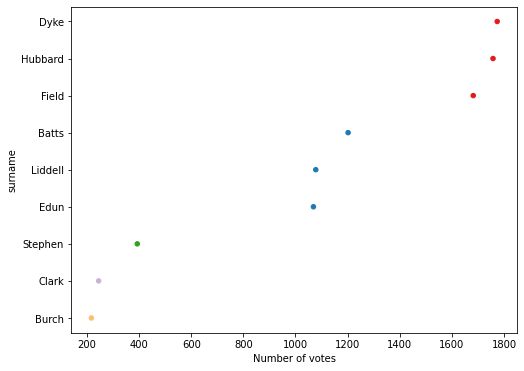

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
8,Williams,John,Local Conservatives,1458,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,John,Williams,Conservative
2,Etheridge,Gary David James,Local Conservatives,1446,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Gary David James,Etheridge,Conservative
6,Turpin,Elizabeth Ann,Local Conservatives,1409,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Elizabeth Ann,Turpin,Conservative
9,Wyatt,Robert Elton,Labour Party,849,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Robert Elton,Wyatt,Labour
5,Thomas,Elaine Orford,Labour Party,786,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Elaine Orford,Thomas,Labour
4,Munton,Derek,Labour Party,742,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Derek,Munton,Labour
0,Atkinson,Neil James,Green Party,379,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Neil James,Atkinson,Green Party
1,Clark,Joanna Elizabeth,Liberal Democrats,304,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Joanna Elizabeth,Clark,Liberal Democrats
3,Millsom,Andrew Lawrence,Liberal Democrats,282,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Andrew Lawrence,Millsom,Liberal Democrats
7,Wells,Alan Edward,Liberal Democrats,219,Strood Rural,https://www.medway.gov.uk/info/200670/local_an...,Alan Edward,Wells,Liberal Democrats


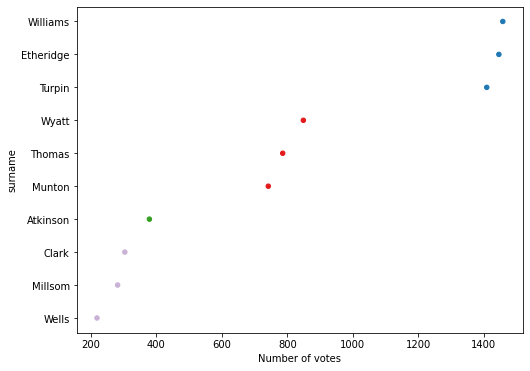

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,Jackson,Sharon Leigh,Labour and Co-operative Party,1338,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Sharon Leigh,Jackson,Labour
6,Jones,Mark William,Labour and Co-operative Party,1291,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Mark William,Jones,Labour
7,Shokar,Satinder Singh,Labour and Co-operative Party,1236,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Satinder Singh,Shokar,Labour
3,Igwe,Ikechukwu (commonly known as Isaac Igwe),Local Conservatives,991,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Isaac Igwe,Igwe,Conservative
4,Iles,Josephine Lesley (commonly known as Josie Iles),Local Conservatives,972,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Josie Iles,Iles,Conservative
0,Buckwell,Christopher Brian (commonly known as Chris Buc...,Local Conservatives,970,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Chris Buckwell,Buckwell,Conservative
1,Griffiths,Susan,Green Party,262,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Susan,Griffiths,Green Party
8,Wild,Michael Dennis,Liberal Democrats,159,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Michael Dennis,Wild,Liberal Democrats
2,Heathfield,Robert John (commonly known as Rob Heathfield),Independent,155,Strood West,https://www.medway.gov.uk/info/200670/local_an...,Rob Heathfield,Heathfield,Independent


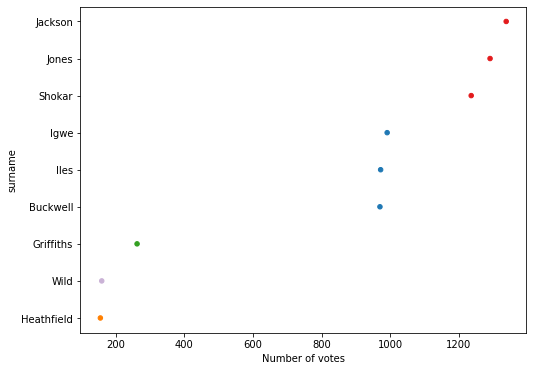

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
2,Brown,Hazel Louise,Labour and Co-operative Party,967,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Hazel Louise,Brown,Labour
3,Prenter,Mark,Labour and Co-operative Party,869,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Mark,Prenter,Labour
1,Brewer,Mitchell,Conservative Party candidate,502,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Mitchell,Brewer,Conservative
5,Smith,Louise Elizabeth,Conservative Party candidate,489,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Louise Elizabeth,Smith,Conservative
0,Belmonte,Catherine Victoria (commonly known as Kate Bel...,Green Party,222,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Kate Belmonte,Belmonte,Green Party
4,Ruparel,Maureen,Liberal Democrats,151,Twydall,https://www.medway.gov.uk/info/200670/local_an...,Maureen,Ruparel,Liberal Democrats


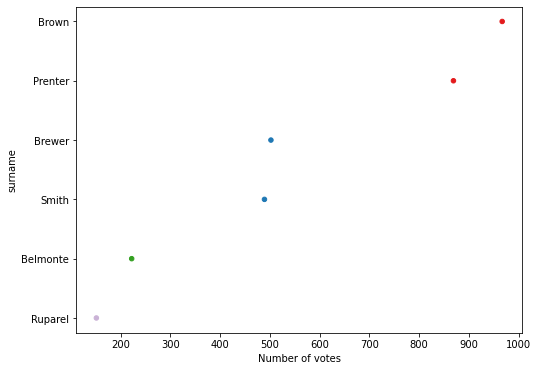

Seats: 3


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
4,Stamp,Christina Melanie (commonly known as Chrissy S...,Labour and Co-operative Party,1998,Watling,https://www.medway.gov.uk/info/200670/local_an...,Chrissy Stamp,Stamp,Labour
0,Coombs,Tracy,Labour and Co-operative Party,1977,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tracy,Coombs,Labour
3,Nestorov,Marian Angelov,Labour and Co-operative Party,1823,Watling,https://www.medway.gov.uk/info/200670/local_an...,Marian Angelov,Nestorov,Labour
1,Marsden,Steven James,Conservative Party candidate,985,Watling,https://www.medway.gov.uk/info/200670/local_an...,Steven James,Marsden,Conservative
6,Venus-Coppard,Tina Louise,Conservative Party candidate,817,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tina Louise,Venus-Coppard,Conservative
5,Strudwick-Long,Adam,Conservative Party candidate,808,Watling,https://www.medway.gov.uk/info/200670/local_an...,Adam,Strudwick-Long,Conservative
2,Munro,Tina,Green Party,361,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tina,Munro,Green Party
7,Yale,David William,Liberal Democrats,313,Watling,https://www.medway.gov.uk/info/200670/local_an...,David William,Yale,Liberal Democrats


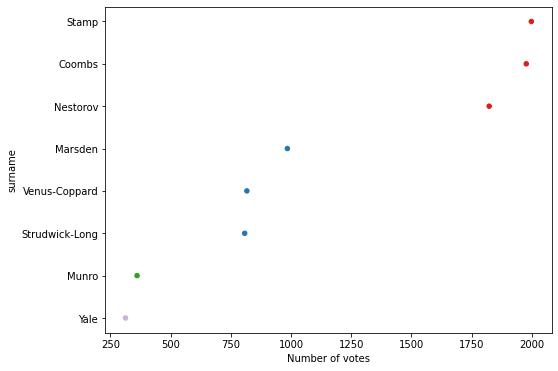

Seats: 2


,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
1,Cook,Esther Mary,Labour and Co-operative Party,986,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Esther Mary,Cook,Labour
4,Peake,Edmund Ralph Barralet (commonly known as Eddie...,Labour and Co-operative Party,915,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Eddie Peake,Peake,Labour
0,Burns,Caroline,Local Conservatives,799,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Caroline,Burns,Conservative
5,Rai,Nawal,Local Conservatives,689,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Nawal,Rai,Conservative
3,Northwood-Boorman,Judith Elizabeth,Green Party,121,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Judith Elizabeth,Northwood-Boorman,Green Party
2,Crack,Herbert John Alfred,Liberal Democrats,108,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Herbert John Alfred,Crack,Liberal Democrats
6,Tanner,Steven (commonly known as Steve Tanner),Social Democratic Party,74,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,Steve Tanner,Tanner,Social Democratic Party


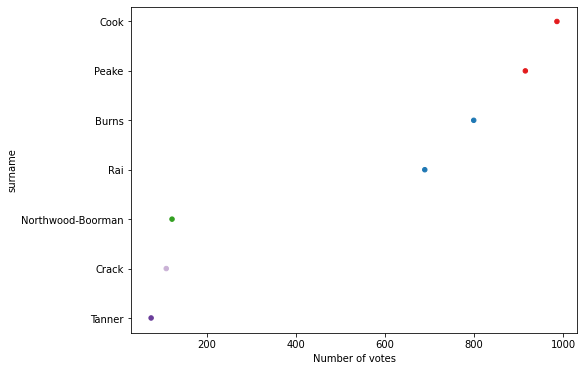

In [10]:
def plot_ward(df):
    (
        df
        .plot(kind='scatter', y='surname', x='Number of votes', figsize=(8,6), c=df['party'].map(map_colors),s=20)
    )
    plt.gca().invert_yaxis()
    plt.show()

    return df

for ward in df_results['ward'].unique():
    display(HTML(f'<h3>{ward}</h3>'))
    
    display(HTML(f'<h4>Overview</h4>'))
    print(f'Seats: {ward_seats.get(ward)}')
    
    display(HTML(f'<h4>Candidate results - table</h4>'))
    df = df_results[df_results['ward'] == ward].sort_values(by='Number of votes', ascending=False)
    display(df)
    display(HTML(f'<h4>Candidate results - graph</h4>'))
    plot_ward(df)
    
    display(HTML(f'<hr/>'))
    
    

In [11]:
df_results[df_results['Surname'] == 'Field']

,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
5,Field,David Peter,Labour and Co-operative Party,1682,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,David Peter,Field,Labour


In [12]:
df_results.sort_values(by='Number of votes', ascending=False).head(15)

,Surname,Other names,Description,Number of votes,ward,ward_result_url,common_name,surname,party
2,Crozer,George Josiah Thomas,Independent,2388,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,George Josiah Thomas,Crozer,Independent
6,Sands,Ronald Philip (commonly known as Ron Sands),Independent,2279,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Ron Sands,Sands,Independent
5,Pearce,Michael Ian,Independent,2230,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,Michael Ian,Pearce,Independent
4,Stamp,Christina Melanie (commonly known as Chrissy S...,Labour and Co-operative Party,1998,Watling,https://www.medway.gov.uk/info/200670/local_an...,Chrissy Stamp,Stamp,Labour
0,Coombs,Tracy,Labour and Co-operative Party,1977,Watling,https://www.medway.gov.uk/info/200670/local_an...,Tracy,Coombs,Labour
3,Nestorov,Marian Angelov,Labour and Co-operative Party,1823,Watling,https://www.medway.gov.uk/info/200670/local_an...,Marian Angelov,Nestorov,Labour
5,Paterson,Alexander John (commonly known as Alex Paterson),Labour and Co-operative Party,1807,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,Alex Paterson,Paterson,Labour
3,Dyke,Zoe Angela Van,Labour and Co-operative Party,1774,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Zoe Angela Van,Dyke,Labour
6,Hubbard,Stephen Alan,Labour and Co-operative Party,1758,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,Stephen Alan,Hubbard,Labour
1,Brake,David Frederick,Local Conservatives,1752,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,David Frederick,Brake,Conservative


### Which party got the most votes overall?

,Number of votes
party,
Labour,63062
Conservative,53841
Independent,7921
Green Party,7741
Liberal Democrats,6978
Heritage Party,217
Christian Peoples Alliance,208
Reform UK,143
Social Democratic Party,132


<AxesSubplot:xlabel='Number of votes', ylabel='party'>

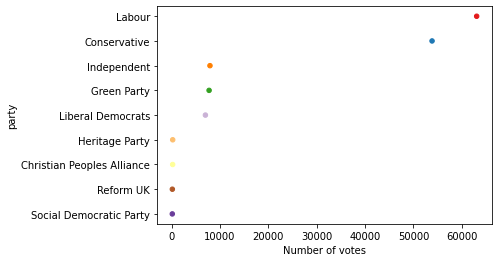

In [13]:


display(df_results.groupby(['party']).sum().sort_values(by='Number of votes', ascending=False))

_df = (
    df_results.groupby(['party']).sum().sort_values(by='Number of votes', ascending=True)
    .reset_index()
)

_df.plot(kind='scatter', x='Number of votes', y='party', c=_df['party'].map(map_colors))

#### 3.2 Analysis - Wards

<AxesSubplot:xlabel='Number of votes', ylabel='ward'>

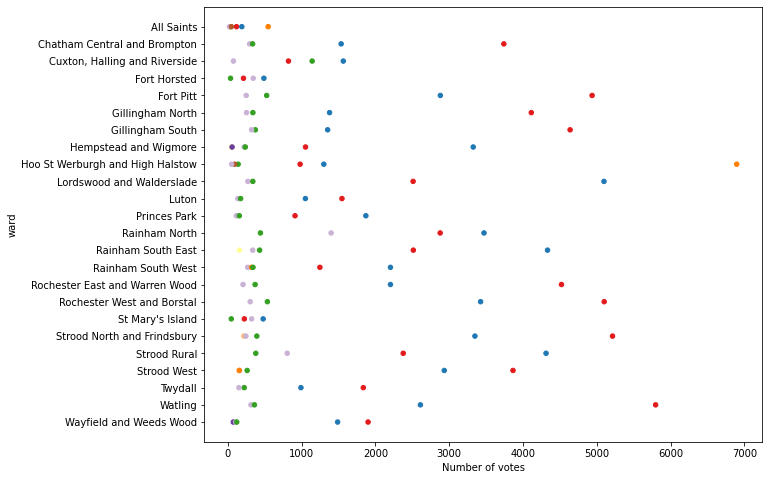

In [14]:
df_results_by_ward = (
    df_results.groupby(['ward', 'party']).sum()
    .reset_index()
    .sort_values(by='ward', ascending=False)
)


df_results_by_ward.plot(kind='scatter', x='Number of votes', y='ward', figsize=(10,8), c=df_results_by_ward['party'].map(map_colors))

<AxesSubplot:xlabel='number_of_votes_norm', ylabel='ward'>

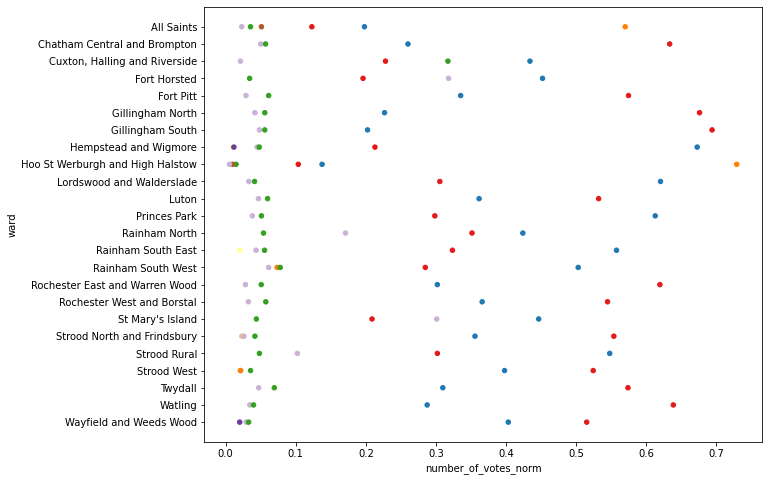

In [15]:
df_results_by_ward = (
    df_results.groupby(['ward', 'party'])['Number of votes'].sum()
    .reset_index()
    .assign(**{'number_of_votes_norm': lambda _df: _df['Number of votes'] / _df.groupby(['ward'])['Number of votes'].transform('sum')})
    .sort_values(by='ward', ascending=False)
)

df_results_by_ward.plot(kind='scatter', x='number_of_votes_norm', y='ward', figsize=(10,8), c=df_results_by_ward['party'].map(map_colors))

In [16]:
### Top parties in wards
df_results_by_ward.sort_values('number_of_votes_norm', ascending=False).groupby('ward').head(1).sort_values(by=['number_of_votes_norm'], ascending=[True])

,ward,party,Number of votes,number_of_votes_norm
54,Rainham North,Conservative,3472,0.423828
10,"Cuxton, Halling and Riverside",Conservative,1565,0.433999
76,St Mary's Island,Conservative,479,0.446412
14,Fort Horsted,Conservative,489,0.451941
63,Rainham South West,Conservative,2204,0.502737
104,Wayfield and Weeds Wood,Labour,1901,0.514897
92,Strood West,Labour,3865,0.524139
48,Luton,Labour,1547,0.531981
74,Rochester West and Borstal,Labour,5101,0.544630
85,Strood Rural,Conservative,4313,0.547752


### How big is the electorate?

In [17]:
print(f"Electorate: {df_wards['electorate'].sum():,}")

Electorate: 200,668


### Which wards had the best turnout?

In [18]:
df_wards.sort_values('turnout', ascending=False)

,ward,url,verified_ballot_papers,verified_postal_ballot_papers,ballot_papers_verified,electorate,turnout,ward_seats
16,Rochester West and Borstal,https://www.medway.gov.uk/info/200670/local_an...,2269,1097,3366,8651,0.389088,3
7,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,1776,844,2620,7463,0.351065,2
4,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,1904,1190,3094,9170,0.337405,3
8,Hoo St Werburgh and High Halstow,https://www.medway.gov.uk/info/200670/local_an...,2346,1003,3349,10049,0.333267,3
17,St Mary's Island,https://www.medway.gov.uk/info/200670/local_an...,673,403,1076,3284,0.327649,1
22,Watling,https://www.medway.gov.uk/info/200670/local_an...,2108,1196,3304,10149,0.325549,3
14,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,1506,849,2355,7309,0.322206,2
18,Strood North and Frindsbury,https://www.medway.gov.uk/info/200670/local_an...,2115,1208,3323,10418,0.318967,3
2,"Cuxton, Halling and Riverside",https://www.medway.gov.uk/info/200670/local_an...,1368,527,1895,6129,0.309186,2
3,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,717,373,1090,3530,0.308782,1


### Which wards mostly use postal votes?

In [19]:
(
    df_wards
    .assign(**{'postal_ballot_perc': lambda _df: _df['verified_postal_ballot_papers'] / _df['ballot_papers_verified']})
    .sort_values(by='postal_ballot_perc', ascending=False)
)

,ward,url,verified_ballot_papers,verified_postal_ballot_papers,ballot_papers_verified,electorate,turnout,ward_seats,postal_ballot_perc
11,Princes Park,https://www.medway.gov.uk/info/200670/local_an...,808,813,1621,6645,0.243943,2,0.501542
23,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,1033,916,1949,7143,0.272855,2,0.469985
1,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,1194,1007,2201,10525,0.209121,3,0.457519
20,Strood West,https://www.medway.gov.uk/info/200670/local_an...,1442,1214,2656,10150,0.261675,3,0.457078
10,Luton,https://www.medway.gov.uk/info/200670/local_an...,848,688,1536,6871,0.223548,2,0.447917
9,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,1658,1336,2994,10857,0.275767,3,0.446226
21,Twydall,https://www.medway.gov.uk/info/200670/local_an...,1003,713,1716,7120,0.241011,2,0.415501
5,Gillingham North,https://www.medway.gov.uk/info/200670/local_an...,1347,880,2227,10237,0.217544,3,0.395150
12,Rainham North,https://www.medway.gov.uk/info/200670/local_an...,1827,1144,2971,10341,0.287303,3,0.385056
4,Fort Pitt,https://www.medway.gov.uk/info/200670/local_an...,1904,1190,3094,9170,0.337405,3,0.384615


### What is the ratio of registered electors to seats?

In [23]:
(
    df_wards
    .assign(**{'ward_seats_per_electorate': lambda _df: _df['electorate'] / _df['ward_seats']})
    .sort_values(by='ward_seats_per_electorate', ascending=False)
)

,ward,url,verified_ballot_papers,verified_postal_ballot_papers,ballot_papers_verified,electorate,turnout,ward_seats,ward_seats_per_electorate
7,Hempstead and Wigmore,https://www.medway.gov.uk/info/200670/local_an...,1776,844,2620,7463,0.351065,2,3731.500000
6,Gillingham South,https://www.medway.gov.uk/info/200670/local_an...,1608,870,2478,11085,0.223545,3,3695.000000
14,Rainham South West,https://www.medway.gov.uk/info/200670/local_an...,1506,849,2355,7309,0.322206,2,3654.500000
9,Lordswood and Walderslade,https://www.medway.gov.uk/info/200670/local_an...,1658,1336,2994,10857,0.275767,3,3619.000000
23,Wayfield and Weeds Wood,https://www.medway.gov.uk/info/200670/local_an...,1033,916,1949,7143,0.272855,2,3571.500000
21,Twydall,https://www.medway.gov.uk/info/200670/local_an...,1003,713,1716,7120,0.241011,2,3560.000000
3,Fort Horsted,https://www.medway.gov.uk/info/200670/local_an...,717,373,1090,3530,0.308782,1,3530.000000
1,Chatham Central and Brompton,https://www.medway.gov.uk/info/200670/local_an...,1194,1007,2201,10525,0.209121,3,3508.333333
0,All Saints,https://www.medway.gov.uk/info/200670/local_an...,634,331,965,3495,0.276109,1,3495.000000
13,Rainham South East,https://www.medway.gov.uk/info/200670/local_an...,1810,1032,2842,10466,0.271546,3,3488.666667
